In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline
import matplotlib.image as mpimg
from collections import deque
import pickle
import os

### Camera Calibration

In [2]:
def calibrate_camera(calib_images, calib_data):
    #Calibration data
    cbrow = 6
    cbcol = 9

    objp = np.zeros((cbrow*cbcol,3), np.float32)
    objp[:,:2] = np.mgrid[0:cbcol, 0:cbrow].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    #images = glob.glob('camera_cal/calibration*.jpg')
    images = glob.glob(calib_images)
    
    # Search for chessboard corners

    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (cbcol,cbrow), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            cv2.imshow('img', img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    #pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
    pickle.dump( dist_pickle, open( calib_data, "wb" ) )
    
    return mtx, dist

In [3]:
from pathlib import Path

calib_images= 'camera_cal/calibration*.jpg'
calib_data='camera_cal/wide_dist_pickle.p'

if Path(calib_data).is_file():
    print('Calibration data loaded...')
    dist_pickle= pickle.load( open( calib_data, "rb" ) )
    mtx= dist_pickle["mtx"]
    dist= dist_pickle["dist"]
else:
    mtx,dist= calibrate_camera(calib_images, calib_data)

Calibration data loaded...


In [4]:
def undistort(img):
    img_undis = cv2.undistort(img, mtx, dist, None, mtx)
    return img_undis

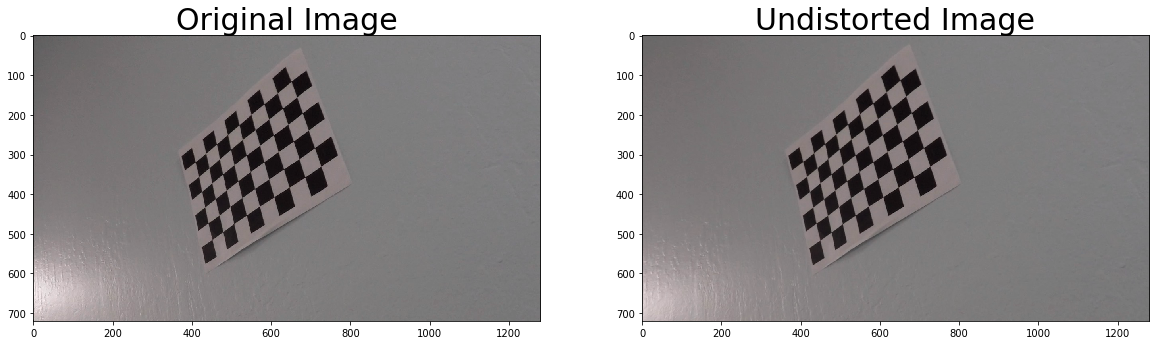

In [5]:
import pickle
%matplotlib inline

images = glob.glob(calib_images)
# Test undistortion on an image
i= np.random.randint(len(images))
file= images[i]
img = cv2.imread(file)

img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

#dst = cv2.undistort(img, mtx, dist, None, mtx)
dst = undistort(img)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [6]:
def bird_eye_view_matrix(src,des):
    
    #Perspective matrix
    A = cv2.getPerspectiveTransform(src, des)
    #inverse perspective matrix
    Ainv = cv2.getPerspectiveTransform(des, src)
    
    return A,Ainv

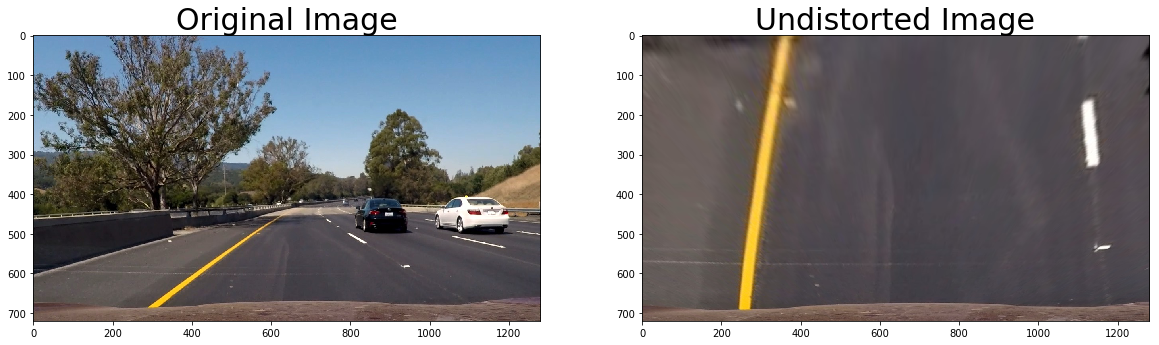

In [7]:
# source points
#src = np.float32([[ 300, 720], [580, 470], [730, 470], [1100, 720]])    
# Destination points
#des = np.float32([(src[0][0]+260, 720), (src[0][0] + 260, 0), (src[-1][0] - 260, 0), (src[-1][0] - 260, 720)])

src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
des = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])

#Compute bird eye view matrix
A,Ainv= bird_eye_view_matrix(src,des)

file='test_images/test6.jpg'
img= cv2.imread(file)
#img = mpimg.imread(file)

binary_warped = cv2.warpPerspective(img, A, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

cv2.imwrite('test_images/test6_warp.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#cv2.imshow(img)
ax1.set_title('Original Image', fontsize=30)
#ax2.imshow(binary_warped, cmap='gray')
ax2.imshow(cv2.cvtColor(binary_warped, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

In [8]:
def color_thresholds0(img):

    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    return combined_binary

In [9]:
def color_thresholds(img):

    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]   

    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    return combined_binary

In [10]:
 def color_thresholds1(img):
    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    return combined_binary

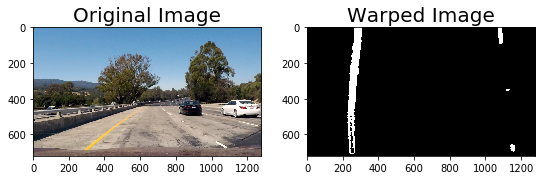

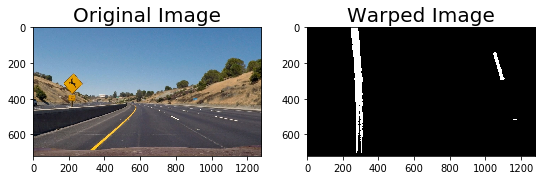

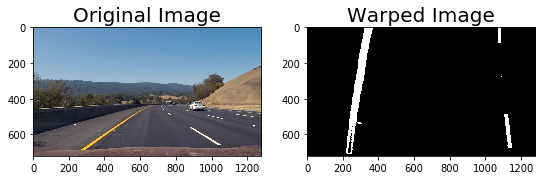

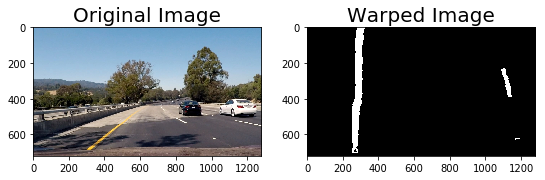

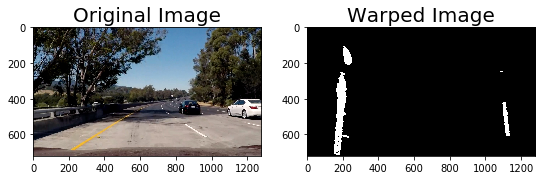

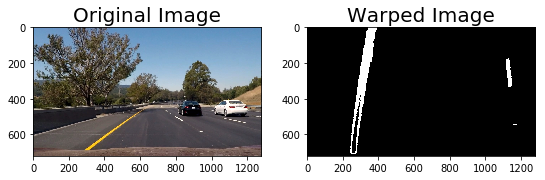

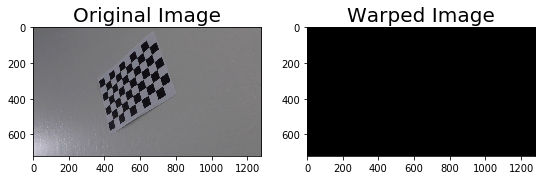

In [11]:
for file in glob.glob('test_images/test*.jpg'):
    img= cv2.imread(file)
    undist = undistort(img)
    warped = cv2.warpPerspective(undist, A, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    warped_th=color_thresholds0(warped)
    
    filename, file_extension = os.path.splitext(file)
    #print(file_extension)
    #cv2.imwrite(filename + '_warp'+file_extension,dst)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax2.set_title('Warped Image', fontsize=20)
    ax2.imshow(warped_th,cmap='gray')
    

In [12]:
def find_line(img):
    
    undist = undistort(img)
    warped = cv2.warpPerspective(undist, A, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    combined_binary=color_thresholds0(warped)

    rightx = []
    righty = []
    leftx = []
    lefty = []
    
    x, y = np.nonzero(np.transpose(combined_binary))
    i = 720
    j = 630
    while j >= 0:
        histogram = np.sum(combined_binary[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    # Measure Radius of Curvature for each lane line
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    #offset = 0 
    #img_size = (img.shape[1], img.shape[0])
    #src = np.float32([[490, 482],[810, 482],
    #                  [1250, 720],[40, 720]])
    #dst = np.float32([[0, 0], [1280, 0], 
    #                 [1250, 720],[40, 720]])
    #Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    #newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    newwarp = cv2.warpPerspective(color_warp, Ainv, (combined_binary.shape[1], combined_binary.shape[0]))
 
    result = cv2.addWeighted(img, 1, newwarp, 0.5, 0)
    
    return result

In [13]:
def line_find(img):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    #print(binary_warped.shape[0]/2)
    undist = undistort(img)
    warped = cv2.warpPerspective(undist, A, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    binary_warped=color_thresholds0(warped)

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    #return out_img,left_fitx,right_fitx,ploty,left_fit,right_fit,leftx,lefty,rightx,righty

    return out_img, left_fit, right_fit

TypeError: expected non-empty vector for x

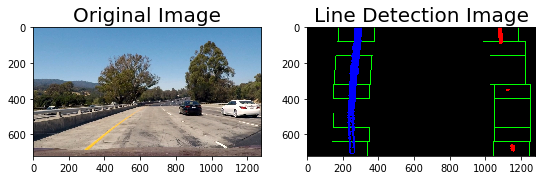

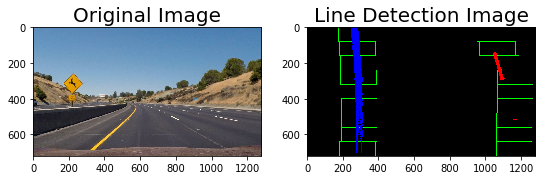

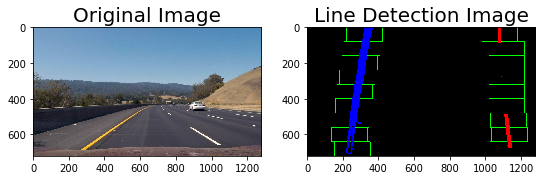

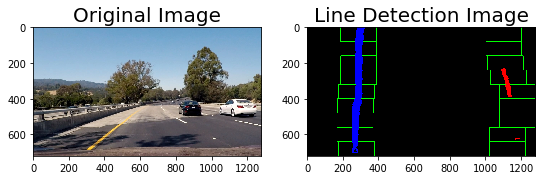

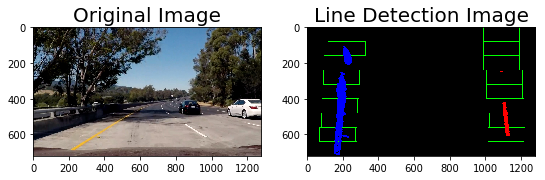

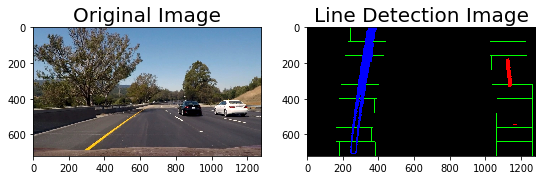

In [14]:
for file in glob.glob('test_images/test*.jpg'):
    img= cv2.imread(file)
    #result=find_line(img)
    result, left_fit, right_fit=line_find(img)

    #print(result.shape)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax2.set_title('Line Detection Image', fontsize=20)
    ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    #ax2.imshow(result,cmap='gray')

In [15]:
def line_tracking(img, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    undist = undistort(img)
    warped = cv2.warpPerspective(undist, A, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    binary_warped=color_thresholds0(warped)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result,left_fit, right_fit, left_fitx, right_fitx, ploty
    
    

In [16]:
def draw_results(image, left_fitx, right_fitx, ploty):

    undist = undistort(image)
    warped0 = cv2.warpPerspective(undist, A, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    warped = cv2.cvtColor(warped0, cv2.COLOR_BGR2GRAY)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    #return color_warp
    #print(pts)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Ainv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

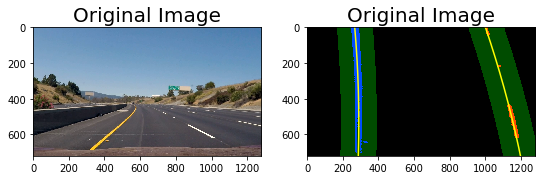

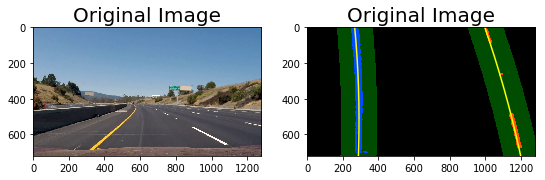

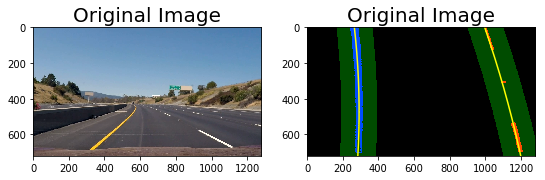

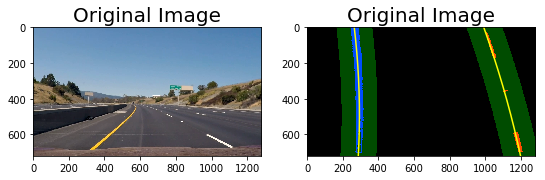

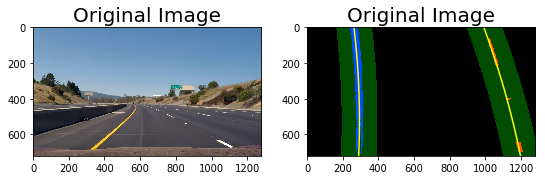

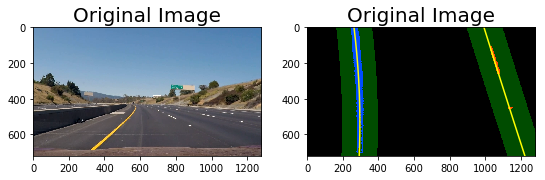

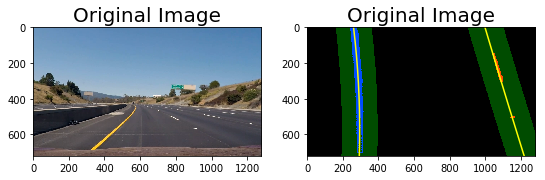

In [17]:
vc = cv2.VideoCapture('project_video.mp4')

if vc.isOpened():
    rval , img = vc.read()
    #img= cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result,left_fit, right_fit=line_find(img)
else:
    rval = False

#print(img.shape)
#result,left_fit, right_fit= line_tracking(img,left_fit,right_fit)


#print(right_fit)
i=0    
while rval:
    rval, img = vc.read()
    #result=line_find(img)
    #print(left_fit)

    #result,left_fit, right_fit= line_tracking(img,left_fit,right_fit)
    result,left_fit, right_fit, left_fitx, right_fitx, ploty=line_tracking(img,left_fit,right_fit)
    
    #print(rval)
    #cv2.imshow('image',frame)
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax2.set_title('Original Image', fontsize=20)
    ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)

    if i>5:
        break
    i=i+1

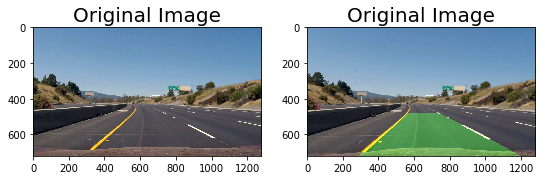

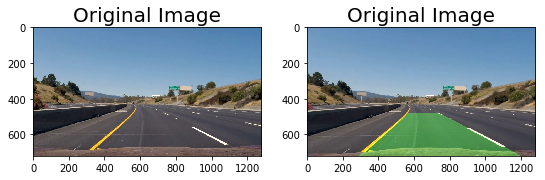

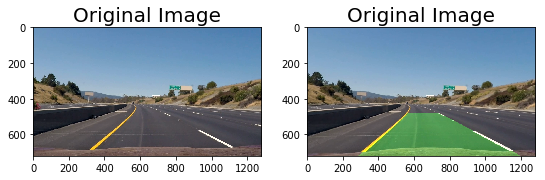

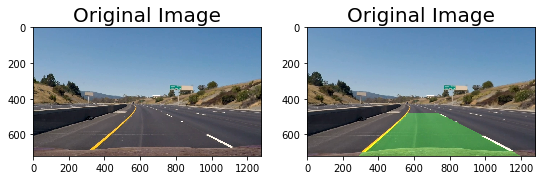

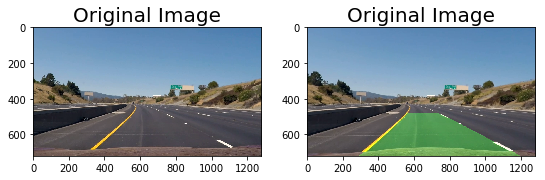

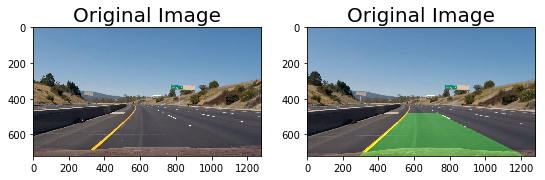

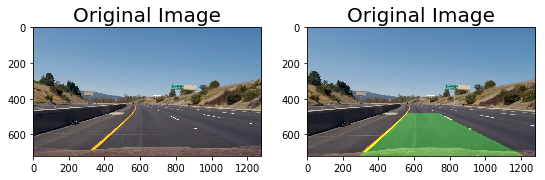

In [18]:
vc = cv2.VideoCapture('project_video.mp4')

if vc.isOpened():
    rval , img = vc.read()
    result,left_fit, right_fit=line_find(img)
else:
    rval = False

#print(img.shape)
#result,left_fit, right_fit= line_tracking(img,left_fit,right_fit)


#print(right_fit)
i=0    
while rval:
    rval, img = vc.read()
    #result=line_find(img)
    #print(left_fit)

    #result,left_fit, right_fit= line_tracking(img,left_fit,right_fit)
    result0,left_fit, right_fit, left_fitx, right_fitx, ploty=line_tracking(img,left_fit,right_fit)
    
    result= draw_results(img, left_fitx, right_fitx, ploty)
    #print(rval)
    #cv2.imshow('image',frame)
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax2.set_title('Original Image', fontsize=20)
    ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    #+ax2.plot(left_fitx, ploty, color='yellow')
    #+ax2.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)

    if i>5:
        break
    i=i+1

In [19]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.fit= None
        self.fitx= None
        
        self.fits= deque(maxlen=10)



In [20]:
def find_lines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    #print(binary_warped.shape[0]/2)
    #undist = undistort(img)
    #warped = cv2.warpPerspective(undist, A, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    #binary_warped=color_thresholds0(warped)

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    Left.detected= len(leftx) > 0 and len(lefty) > 0
    Right.detected= len(rightx) > 0 and len(righty) > 0
    
    if Left.detected:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        Left.fits.append(left_fit)
    else:
        left_fit= np.mean(Left.fits,axis=0)
    
    if Right.detected:
        # Fit a second order polynomial to each
        right_fit = np.polyfit(righty, rightx, 2)    
        Right.fits.append(right_fit)
    else:
        right_fit= np.mean(Right.fits,axis=0)

    #left_fit= np.mean(Left.fits,axis=0)
    #right_fit= np.mean(Right.fits,axis=0)
    
    #if Left.detected and Right.detected:
    # Fit a second order polynomial to each
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)

    #Left.fits.append(left_fit)
    #Right.fits.append(right_fit)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    #return out_img,left_fitx,right_fitx,ploty,left_fit,right_fit,leftx,lefty,rightx,righty
    #return out_img, left_fit, right_fit

    Left.fit= left_fit
    Right.fit= right_fit

    Left.fitx= left_fitx
    Right.fitx= right_fitx
    
    #Left.detected= True
    #Right.detected= True
    
    
    return out_img, ploty

In [21]:
def track_line(img, binary_warped):
#def track_line(img, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    #undist = undistort(img)
    #warped = cv2.warpPerspective(undist, A, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    #binary_warped=color_thresholds0(warped)

    left_fit= Left.fit
    right_fit= Right.fit
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    Left.detected= len(leftx) == 0 or len(lefty)
    Right.detected= len(rightx) == 0 or len(righty) == 0
    
    if Left.detected:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        Left.fits.append(left_fit)
    
    if Right.detected:
        # Fit a second order polynomial to each
        right_fit = np.polyfit(righty, rightx, 2)    
        Right.fits.append(right_fit)

    left_fit= np.mean(Left.fits,axis=0)
    right_fit= np.mean(Right.fits,axis=0)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    Left.fit= left_fit
    Right.fit= right_fit

    Left.fitx= left_fitx
    Right.fitx= right_fitx

    #return result,left_fit, right_fit, left_fitx, right_fitx, ploty
    return result, ploty

In [22]:
def process_video(img):
    #global count
    #print(count)
    undist = undistort(img)
    warped = cv2.warpPerspective(undist, A, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    #binary_warped=color_thresholds0(warped)
    binary_warped=color_thresholds(warped)

    if Left.detected == True and Right.detected == True:
        result, ploty= track_line(img, binary_warped)
        
    if Left.detected == False or Right.detected == False:
        result, ploty=find_lines(binary_warped)
    
    #result, ploty=find_lines(binary_warped)
    
    #result= draw_results(img, left_fitx, ploty)
    result= draw_results(img, Left.fitx, Right.fitx, ploty)
    #print(ploty)
    
    #count= count + 1
    return result


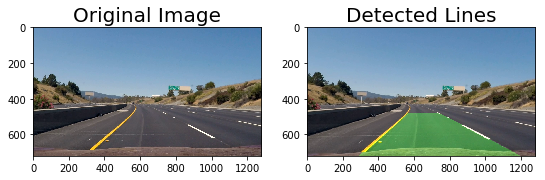

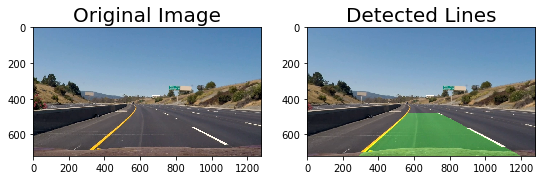

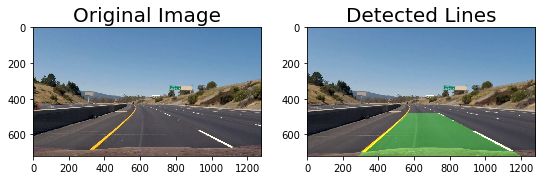

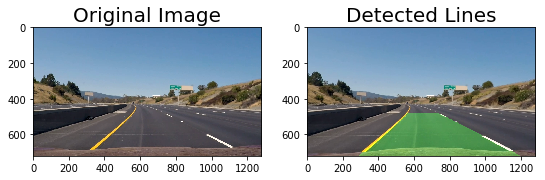

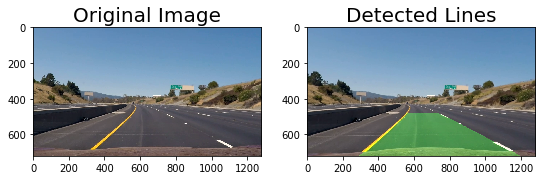

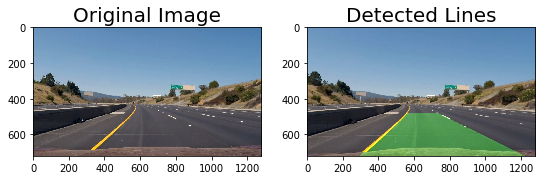

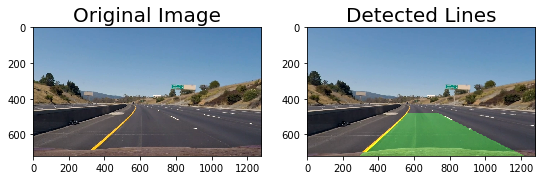

In [25]:
Left=Line()
Right=Line()

vc = cv2.VideoCapture('project_video.mp4')

if vc.isOpened():
    rval , img = vc.read()
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result= process_video(img)
else:
    rval = False

#print(img.shape)
#result,left_fit, right_fit= line_tracking(img,left_fit,right_fit)


#print(right_fit)
i=0    
while rval:
    rval, img = vc.read()
    #result=line_find(img)
    #print(left_fit)

    #result,left_fit, right_fit= line_tracking(img,left_fit,right_fit)
    #result0,left_fit, right_fit, left_fitx, right_fitx, ploty=line_tracking(img,left_fit,right_fit)
    
    #result= draw_results(img, left_fitx, ploty)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result= process_video(img)    

    #print(rval)
    #cv2.imshow('image',frame)
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.set_title('Original Image', fontsize=20)
    #ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.imshow(img)
    ax2.set_title('Detected Lines', fontsize=20)
    #ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    ax2.imshow(result)
    #+ax2.plot(left_fitx, ploty, color='yellow')
    #+ax2.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)

    if i>5:
        break
    i=i+1

In [27]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:
Left = Line()
Right = Line()
video_output = 'video_result.mp4'
count=0
#clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(process_video) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video video_result.mp4
[MoviePy] Writing video video_result.mp4


100%|█████████▉| 1260/1261 [03:30<00:00,  5.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_result.mp4 



In [42]:
class Line:
    def __init__(self):
        self.found = False
        
        self.X = None
        self.Y = None
        
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        self.lastx_int = None
        self.last_top = None
        
        self.radius = None
        
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0

    def track_line(self, x, y):
        #track previous line found
     
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            window_height= 90
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                index = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[index], y[index]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= window_height
                j -= window_height
        if np.sum(xvals) == 0: 
            self.found = False 
        return xvals, yvals, self.found
    
    def find_line(self, x, y, image):
        #find the line
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    # Find the peak of the right halves of the histogram
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    # Find the peak of the left halves of the histogram
                    peak = np.argmax(histogram[:640])
                idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[idx], y[idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def curvature(self, xvals, yvals):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30./720 
        xm_per_pix = 3.7/700 
        
        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) /np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_values(self, x, y):
        index = np.argsort(y)
        y_sorted = y[index]
        x_sorted = x[index]
        return x_sorted, y_sorted
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

In [51]:
# Video Processing Pipeline
def process_vid(image):
    img_size = (image.shape[1], image.shape[0])
    
    undist = undistort(image)
    
    warped = cv2.warpPerspective(undist, A, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    
    binary=color_thresholds(warped)
    
    # Find non zero pixels in the image
    x, y = np.nonzero(np.transpose(binary)) 

    if Left.found == True: # Search for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.track_line(x, y)
        
    if Right.found == True: # Search for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.track_line(x, y)

            
    if Right.found == False: # Perform blind search for right lane lines
        rightx, righty, Right.found = Right.find_line(x, y, binary)
       
    if Left.found == False:# Perform blind search for left lane lines
        leftx, lefty, Left.found = Left.find_line(x, y, binary)
   
    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_values(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    #Estimate top and bottom image interception
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    rightx, righty = Right.sort_values(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # Compute polynomial with previous frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Estimate curvature
    left_curverad = Left.curvature(leftx, lefty)
    right_curverad = Right.curvature(rightx, righty)
        
    # Print the radius every 5 frames
    if Left.count == 5:
        Left.radius = left_curverad
        Right.radius = right_curverad
        Left.count= 0
        
    # Vehice position
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
   
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    
    # Warp the blank back to original image space using inverse perspective matrix (Ainv)
    warp2 = cv2.warpPerspective(color_warp, Ainv, (image.shape[1], image.shape[0]))

    result = cv2.addWeighted(undist, 1, warp2, 0.5, 0)
        
    Left.count += 1
    return result

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [52]:
Left = Line()
Right = Line()
video_output = 'video_result.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
#clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video video_result.mp4
[MoviePy] Writing video video_result.mp4


 99%|█████████▉| 125/126 [00:24<00:00,  5.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_result.mp4 



In [53]:
Left = Line()
Right = Line()
video_output = 'challenge_video_result.mp4'
#clip1 = VideoFileClip("challenge_video.mp4").subclip(0,2)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_result.mp4
[MoviePy] Writing video challenge_video_result.mp4


100%|██████████| 485/485 [01:17<00:00,  5.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_result.mp4 

